# Intermittent Math Modelling

This notebook focuses on mathematical modeling of intermittent treatment data for cancer cell growth dynamics.
Data is extracted from the organized processed datasets with exact seeding densities (20k and 30k).

In [1]:
# Essential packages for intermittent treatment modeling should only run once per project
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("DifferentialEquations")
Pkg.add("Optimization")
Pkg.add("OptimizationOptimJL")
Pkg.add("OptimizationBBO")
Pkg.add("DiffEqParamEstim")
Pkg.add("StatsBase")
Pkg.add("SciMLSensitivity")
Pkg.add("BlackBoxOptim")
Pkg.add("StatsPlots")
Pkg.add("DataFramesMeta")
Pkg.add("Interact")
Pkg.add("Random")
Pkg.add("Distributions")

    Updating registry at `C:\Users\MainFrameTower\.julia\registries\General.toml`
   Resolving package versions...
   Installed IteratorInterfaceExtensions ─ v1.0.0
   Installed DataAPI ───────────────────── v1.16.0
   Installed SentinelArrays ────────────── v1.4.8
   Installed PooledArrays ──────────────── v1.4.3
   Installed InlineStrings ─────────────── v1.4.5
   Installed TableTraits ───────────────── v1.0.1
   Installed Tables ────────────────────── v1.12.1
   Installed IteratorInterfaceExtensions ─ v1.0.0
   Installed DataAPI ───────────────────── v1.16.0
   Installed SentinelArrays ────────────── v1.4.8
   Installed PooledArrays ──────────────── v1.4.3
   Installed InlineStrings ─────────────── v1.4.5
   Installed TableTraits ───────────────── v1.0.1
   Installed Tables ────────────────────── v1.12.1
   Installed DataValueInterfaces ───────── v1.0.0
   Installed DataValueInterfaces ───────── v1.0.0
   Installed Compat ────────────────────── v4.18.0
   Installed Compat ──────────

In [2]:
using CSV
using DataFrames
using Plots
using DifferentialEquations
using Optimization, OptimizationOptimJL, OptimizationBBO
using BlackBoxOptim
using StatsBase
using Random
using Distributions
using Printf
using Statistics

In [3]:
# Core modeling functions
function setUpProblem(modelTypeSet, xdataSet, ydataSet, solverSet, u0Set, pSet, tspanSet, boundsSet)
    best_params, best_sol, best_prob, best_loss = nothing, nothing, nothing, Inf

    for _ in 1:5
        p_init = [lo[1] == lo[2] ? lo[1] : rand(Uniform(lo[1], lo[2])) for lo in boundsSet]

        try
            prob = ODEProblem(modelTypeSet, u0Set, tspanSet, p_init)
            loss_func = build_loss_objective(prob, solverSet, L2Loss(xdataSet, ydataSet), Optimization.AutoForwardDiff())
            result = bboptimize(loss_func; SearchRange=boundsSet, MaxTime=30.0, TraceMode=:silent)
            p_opt = best_candidate(result)
            sol = solve(remake(prob, p=p_opt), solverSet, saveat=xdataSet)
            loss = sum(abs2.(ydataSet .- [u[1] for u in sol.u]))

            if loss < best_loss
                best_params, best_sol, best_prob, best_loss = p_opt, sol, prob, loss
            end
        catch; end
    end

    return best_params, best_sol, best_prob
end

function calculate_bic(probbic, xdatabic, ydatabic, solverbic, optparbic)
    solbic = solve(probbic, solverbic, reltol=1e-15, abstol=1e-15, saveat=xdatabic)
    residualsbic = [ydatabic[i] - solbic(xdatabic[i])[1] for i in 1:length(xdatabic)]
    ssrbic = sum(residualsbic .^ 2)
    kbic = length(optparbic)
    nbic = length(xdatabic)
    bic = nbic * log(ssrbic / nbic) + kbic * log(nbic)
    return bic, ssrbic
end

function plot_model_fit(x, y, optimized_params, optimized_sol, bic, ssr, title_str)
    println("\nOptimized Parameters: ", round.(optimized_params, digits=4))
    println("Sum of Squared Residuals (SSR): ", round(ssr, digits=6))
    println("Bayesian Information Criterion (BIC): ", round(bic, digits=2))
    
    p = plot(x, y, label="Data", legend=:bottomright, title=title_str, xlabel="Day", ylabel="Cell Count", 
             lw=2, marker=:circle, markersize=4)
    plot!(optimized_sol.t, [u[1] for u in optimized_sol.u], label="Model", lw=3, linestyle=:dash)
    
    display(p)
    return p
end

plot_model_fit (generic function with 1 method)

In [17]:
# Load intermittent data from processed datasets
function load_intermittent_data(seeding_density::String)
    base_path = "Processed_Datasets/Intermittent Data/$(seeding_density)_seeding_density/Averages/"
    
    # Define file mappings
    files = [
        "A2780T_dayaverages.csv",     # Naive treated
        "A2780UT_dayaverages.csv",    # Naive untreated  
        "A2780cisT_dayaverages.csv",  # Resistant treated
        "A2780cisUT_dayaverages.csv"  # Resistant untreated
    ]
    
    datasets = Dict{String, DataFrame}()
    
    for file in files
        try
            df = CSV.read(base_path * file, DataFrame)
            datasets[file] = df
            println("✅ Loaded: ", file, " ($(nrow(df)) rows)")
        catch e
            println("❌ Failed to load: $file")
            println("   ↳ Error: ", e)
        end
    end
    
    return datasets
end

# Extract x,y data from day averages CSV (data is already preprocessed)
function extract_xy_from_dayaverages(df::DataFrame)
    # Extract day and cell count data from preprocessed CSV
    x = Float64.(df[:, 1])  # First column (days)
    y = Float64.(df[:, 2])  # Second column (cell counts) - already processed
    
    println("   → Data range: Day $(x[1])-$(x[end]), Cell count $(minimum(y))-$(maximum(y))")
    return x, y
end

extract_xy_from_dayaverages (generic function with 1 method)

In [18]:
# Mathematical models for intermittent treatment

# 1. Standard logistic growth (for comparison)
function logistic_growth!(du, u, p, t)
    r, K = p
    du[1] = r * u[1] * (1 - u[1] / K)
end

# 2. Early treatment with lingering decay (T files: treated 0-7, untreated 7-14)
function early_treatment_decay!(du, u, p, t)
    r, K, drug_effect, decay_rate = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment (days 0-7): full drug effect
        current_drug_effect = drug_effect
    else
        # Post-treatment (days 7-14): exponential decay of lingering effect
        time_since_treatment = t - treatment_end
        current_drug_effect = drug_effect * exp(-time_since_treatment / decay_rate)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 3. Late treatment (UT files: untreated 0-7, treated 7-14)
function late_treatment!(du, u, p, t)
    r, K, drug_effect = p
    N = u[1]
    
    treatment_start = 7.0
    if t <= treatment_start
        # Pre-treatment (days 0-7): no drug effect
        current_drug_effect = 0.0
    else
        # During treatment (days 7-14): full drug effect
        current_drug_effect = drug_effect
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 4. Early treatment with biphasic decay (fast + slow clearance)
function early_treatment_biphasic!(du, u, p, t)
    r, K, drug_effect, fast_decay, slow_decay, fast_fraction = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment: full effect
        current_drug_effect = drug_effect
    else
        # Post-treatment: biphasic decay
        time_since_end = t - treatment_end
        fast_component = fast_fraction * exp(-time_since_end / fast_decay)
        slow_component = (1 - fast_fraction) * exp(-time_since_end / slow_decay)
        current_drug_effect = drug_effect * (fast_component + slow_component)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 5. Early treatment with power law decay (very persistent effects)
function early_treatment_powerlaw!(du, u, p, t)
    r, K, drug_effect, decay_exponent, time_scale = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment: full effect
        current_drug_effect = drug_effect
    else
        # Post-treatment: power law decay
        time_since_end = t - treatment_end
        current_drug_effect = drug_effect / (1 + (time_since_end / time_scale)^decay_exponent)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 6. Late treatment with immediate effect buildup
function late_treatment_buildup!(du, u, p, t)
    r, K, drug_effect, buildup_rate = p
    N = u[1]
    
    treatment_start = 7.0
    if t <= treatment_start
        # Pre-treatment: no effect
        current_drug_effect = 0.0
    else
        # During treatment: gradual buildup to full effect
        time_in_treatment = t - treatment_start
        current_drug_effect = drug_effect * (1 - exp(-time_in_treatment / buildup_rate))
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 7. Early treatment with Hill effect (T files: treated 0-7, untreated 7-14)
function early_treatment_hill!(du, u, p, t)
    r, K, max_drug_effect, hill_coeff, half_effect_time = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment: Hill function increases effect over time
        current_drug_effect = max_drug_effect * (t^hill_coeff) / (t^hill_coeff + half_effect_time^hill_coeff)
    else
        # Post-treatment: no drug effect (immediate clearance)
        current_drug_effect = 0.0
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 8. Late treatment with Hill effect (UT files: untreated 0-7, treated 7-14)
function late_treatment_hill!(du, u, p, t)
    r, K, max_drug_effect, hill_coeff, half_effect_time = p
    N = u[1]
    
    treatment_start = 7.0
    if t <= treatment_start
        # Pre-treatment: no drug effect
        current_drug_effect = 0.0
    else
        # During treatment: Hill function increases effect over time in treatment
        time_in_treatment = t - treatment_start
        current_drug_effect = max_drug_effect * (time_in_treatment^hill_coeff) / (time_in_treatment^hill_coeff + half_effect_time^hill_coeff)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

late_treatment_hill! (generic function with 1 method)

Loading 20k seeding density data...
✅ Loaded: A2780T_dayaverages.csv
✅ Loaded: A2780UT_dayaverages.csv
✅ Loaded: A2780cisT_dayaverages.csv
✅ Loaded: A2780cisUT_dayaverages.csv

📊 Processing: A2780cisT_dayaverages.csv
   → Fitting treatment models

📊 Processing: A2780T_dayaverages.csv
   → Fitting treatment models

📊 Processing: A2780cisUT_dayaverages.csv
   → Fitting logistic growth model

📊 Processing: A2780UT_dayaverages.csv
   → Fitting logistic growth model

📈 Displaying summary plots for 20k seeding density...
   → Fitting treatment models

📊 Processing: A2780T_dayaverages.csv
   → Fitting treatment models

📊 Processing: A2780cisUT_dayaverages.csv
   → Fitting logistic growth model

📊 Processing: A2780UT_dayaverages.csv
   → Fitting logistic growth model

📈 Displaying summary plots for 20k seeding density...


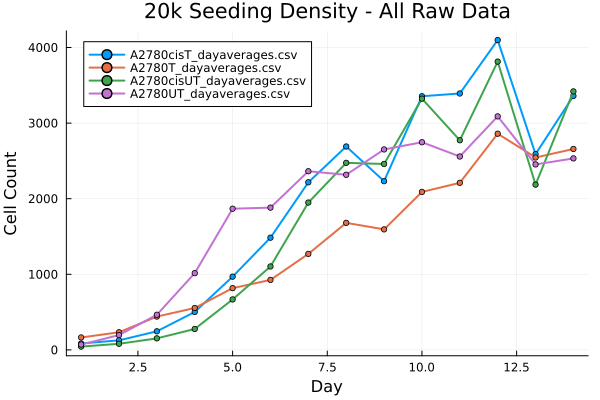

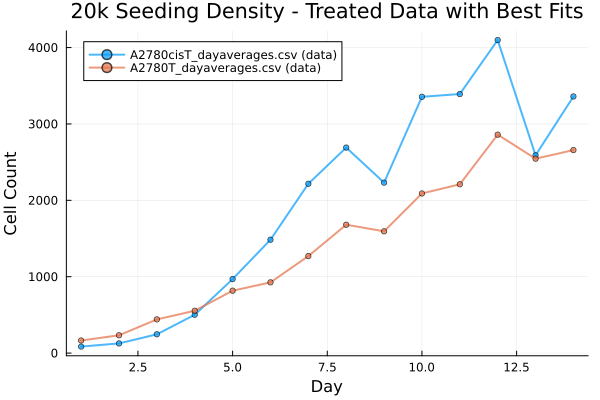

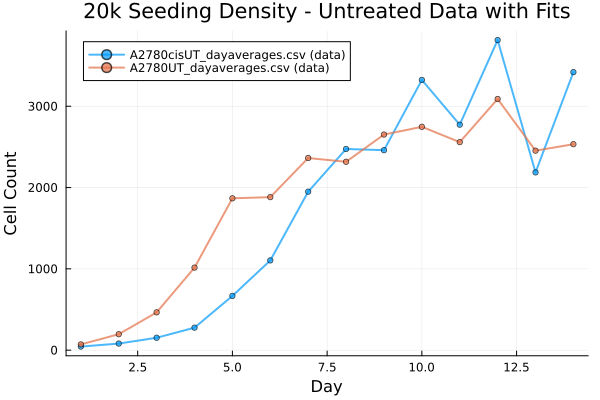

In [ ]:
# Load and analyze 20k seeding density data
println("Loading 20k seeding density data...")
datasets_20k = load_intermittent_data("20k")

# Initialize storage for results
results_20k = Dict{String, Any}()
xy_data_20k = Dict{String, Tuple{Vector{Float64}, Vector{Float64}}}()

# Create plots to store all data
plot_all_raw = plot(title="20k Seeding Density - All Raw Data", xlabel="Day", ylabel="Cell Count", legend=:topleft)
plot_treated_early = plot(title="20k - Early Treatment (T files): Treated 0-7, Untreated 7-14", xlabel="Day", ylabel="Cell Count", legend=:topleft)
plot_treated_late = plot(title="20k - Late Treatment (UT files): Untreated 0-7, Treated 7-14", xlabel="Day", ylabel="Cell Count", legend=:topleft)

# Process each dataset
for (filename, df) in datasets_20k
    println("\n📊 Processing: $filename")
    
    # Extract x,y data
    x, y = extract_xy_from_dayaverages(df)
    xy_data_20k[filename] = (x, y)
    
    # Add raw data to overview plot
    plot!(plot_all_raw, x, y, label=filename, lw=2, marker=:circle, markersize=3)
    
    # Set up common parameters
    solver = Rodas5()
    tspan = (x[1], x[end])
    u0 = [y[1]]
    
    # Determine treatment type based on filename
    is_early_treatment = occursin("T_", filename) && !occursin("UT_", filename)  # T files
    is_late_treatment = occursin("UT_", filename)  # UT files
    
    if is_early_treatment
        println("   → Early treatment (T): Treated days 0-7, untreated days 7-14")
        
        # Add raw data to early treatment plot
        plot!(plot_treated_early, x, y, label="$filename (data)", lw=2, marker=:circle, markersize=3, alpha=0.7)
        
        # Try early treatment models with lingering effects
        models_to_try = [
            (early_treatment_decay!, [(0.0, 2.0), (100.0, 50000.0), (0.0, 0.95), (0.5, 10.0)], "Early + Exponential Decay"),
            (early_treatment_biphasic!, [(0.0, 2.0), (100.0, 50000.0), (0.0, 0.95), (0.5, 3.0), (2.0, 10.0), (0.3, 0.8)], "Early + Biphasic Decay"),
            (early_treatment_powerlaw!, [(0.0, 2.0), (100.0, 50000.0), (0.0, 0.95), (0.5, 3.0), (1.0, 5.0)], "Early + Power Law Decay"),
            (early_treatment_hill!, [(0.0, 2.0), (100.0, 50000.0), (0.0, 0.95), (1.0, 5.0), (1.0, 7.0)], "Early + Hill Effect")
        ]
        
        file_results = []
        
        for (model, bounds, name) in models_to_try
            p_init = [mean(b) for b in bounds]
            
            try
                opt_params, opt_sol, opt_prob = setUpProblem(model, x, y, solver, u0, p_init, tspan, bounds)
                
                if opt_params !== nothing
                    bic, ssr = calculate_bic(opt_prob, x, y, solver, opt_params)
                    push!(file_results, (name, opt_params, opt_sol, opt_prob, bic, ssr))
                    
                    # Plot the individual fit
                    plot_model_fit(x, y, opt_params, opt_sol, bic, ssr, "$filename - $name Model")
                end
            catch e
                println("   ⚠️ Failed to fit $name model: $e")
            end
        end
        
        # Add best fit to comparison plot
        if !isempty(file_results)
            best_result = sort(file_results, by = x -> x[5])[1]  # Sort by BIC
            best_name, best_params, best_sol, best_prob, best_bic, best_ssr = best_result
            plot!(plot_treated_early, best_sol.t, [u[1] for u in best_sol.u], 
                  label="$filename ($best_name fit)", lw=3, linestyle=:dash)
        end
        
        results_20k[filename] = file_results
        
    elseif is_late_treatment
        println("   → Late treatment (UT): Untreated days 0-7, treated days 7-14")
        
        # Add raw data to late treatment plot
        plot!(plot_treated_late, x, y, label="$filename (data)", lw=2, marker=:circle, markersize=3, alpha=0.7)
        
        # Try late treatment models
        models_to_try = [
            (late_treatment!, [(0.0, 2.0), (100.0, 50000.0), (0.0, 0.95)], "Late Treatment"),
            (late_treatment_buildup!, [(0.0, 2.0), (100.0, 50000.0), (0.0, 0.95), (0.5, 5.0)], "Late + Gradual Buildup"),
            (late_treatment_hill!, [(0.0, 2.0), (100.0, 50000.0), (0.0, 0.95), (1.0, 5.0), (1.0, 7.0)], "Late + Hill Effect")
        ]
        
        file_results = []
        
        for (model, bounds, name) in models_to_try
            p_init = [mean(b) for b in bounds]
            
            try
                opt_params, opt_sol, opt_prob = setUpProblem(model, x, y, solver, u0, p_init, tspan, bounds)
                
                if opt_params !== nothing
                    bic, ssr = calculate_bic(opt_prob, x, y, solver, opt_params)
                    push!(file_results, (name, opt_params, opt_sol, opt_prob, bic, ssr))
                    
                    # Plot the individual fit
                    plot_model_fit(x, y, opt_params, opt_sol, bic, ssr, "$filename - $name Model")
                end
            catch e
                println("   ⚠️ Failed to fit $name model: $e")
            end
        end
        
        # Add best fit to comparison plot
        if !isempty(file_results)
            best_result = sort(file_results, by = x -> x[5])[1]  # Sort by BIC
            best_name, best_params, best_sol, best_prob, best_bic, best_ssr = best_result
            plot!(plot_treated_late, best_sol.t, [u[1] for u in best_sol.u], 
                  label="$filename ($best_name fit)", lw=3, linestyle=:dash)
        end
        
        results_20k[filename] = file_results
        
    else
        println("   → Unknown treatment type - skipping")
        results_20k[filename] = []
    end
end

# Display summary plots
println("\n📈 Displaying summary plots for 20k seeding density...")
display(plot_all_raw)
display(plot_treated_early)
display(plot_treated_late)

# Create model comparison plots
println("\n📊 Creating model comparison plots...")

# Early treatment comparison
early_files = [k for k in keys(results_20k) if occursin("T_", k) && !occursin("UT_", k) && !isempty(results_20k[k])]
if !isempty(early_files)
    plot_early_comparison = plot(title="20k Early Treatment - Model Comparison (BIC Values)", 
                                xlabel="Dataset", ylabel="BIC Value", legend=:topright)
    
    datasets_early = []
    bic_values_exp = []
    bic_values_biphasic = []
    bic_values_power = []
    bic_values_hill = []
    
    for filename in early_files
        file_results = results_20k[filename]
        push!(datasets_early, replace(filename, ".csv" => ""))
        
        exp_idx = findfirst(x -> x[1] == "Early + Exponential Decay", file_results)
        biphasic_idx = findfirst(x -> x[1] == "Early + Biphasic Decay", file_results)
        power_idx = findfirst(x -> x[1] == "Early + Power Law Decay", file_results)
        hill_idx = findfirst(x -> x[1] == "Early + Hill Effect", file_results)
        
        push!(bic_values_exp, exp_idx !== nothing ? file_results[exp_idx][5] : NaN)
        push!(bic_values_biphasic, biphasic_idx !== nothing ? file_results[biphasic_idx][5] : NaN)
        push!(bic_values_power, power_idx !== nothing ? file_results[power_idx][5] : NaN)
        push!(bic_values_hill, hill_idx !== nothing ? file_results[hill_idx][5] : NaN)
    end
    
    if !isempty(datasets_early)
        x_pos = 1:length(datasets_early)
        bar!(plot_early_comparison, x_pos .- 0.3, bic_values_exp, width=0.2, label="Exponential Decay", alpha=0.7)
        bar!(plot_early_comparison, x_pos .- 0.1, bic_values_biphasic, width=0.2, label="Biphasic Decay", alpha=0.7)
        bar!(plot_early_comparison, x_pos .+ 0.1, bic_values_power, width=0.2, label="Power Law Decay", alpha=0.7)
        bar!(plot_early_comparison, x_pos .+ 0.3, bic_values_hill, width=0.2, label="Hill Effect", alpha=0.7)
        plot!(plot_early_comparison, xticks=(x_pos, datasets_early), xrotation=45)
        display(plot_early_comparison)
    end
end

# Late treatment comparison
late_files = [k for k in keys(results_20k) if occursin("UT_", k) && !isempty(results_20k[k])]
if !isempty(late_files)
    plot_late_comparison = plot(title="20k Late Treatment - Model Comparison (BIC Values)", 
                               xlabel="Dataset", ylabel="BIC Value", legend=:topright)
    
    datasets_late = []
    bic_values_simple = []
    bic_values_buildup = []
    bic_values_hill = []
    
    for filename in late_files
        file_results = results_20k[filename]
        push!(datasets_late, replace(filename, ".csv" => ""))
        
        simple_idx = findfirst(x -> x[1] == "Late Treatment", file_results)
        buildup_idx = findfirst(x -> x[1] == "Late + Gradual Buildup", file_results)
        hill_idx = findfirst(x -> x[1] == "Late + Hill Effect", file_results)
        
        push!(bic_values_simple, simple_idx !== nothing ? file_results[simple_idx][5] : NaN)
        push!(bic_values_buildup, buildup_idx !== nothing ? file_results[buildup_idx][5] : NaN)
        push!(bic_values_hill, hill_idx !== nothing ? file_results[hill_idx][5] : NaN)
    end
    
    if !isempty(datasets_late)
        x_pos = 1:length(datasets_late)
        bar!(plot_late_comparison, x_pos .- 0.2, bic_values_simple, width=0.25, label="Simple Step", alpha=0.7)
        bar!(plot_late_comparison, x_pos, bic_values_buildup, width=0.25, label="Gradual Buildup", alpha=0.7)
        bar!(plot_late_comparison, x_pos .+ 0.2, bic_values_hill, width=0.25, label="Hill Effect", alpha=0.7)
        plot!(plot_late_comparison, xticks=(x_pos, datasets_late), xrotation=45)
        display(plot_late_comparison)
    end
end


Loading 30k seeding density data...
✅ Loaded: A2780T_dayaverages.csv
✅ Loaded: A2780UT_dayaverages.csv
✅ Loaded: A2780cisT_dayaverages.csv
✅ Loaded: A2780cisUT_dayaverages.csv

📊 Processing: A2780cisT_dayaverages.csv
   → Adding to treated plot (no model fitting)

📊 Processing: A2780T_dayaverages.csv
   → Adding to treated plot (no model fitting)

📊 Processing: A2780cisUT_dayaverages.csv
   → Adding to untreated plot (no model fitting)

📊 Processing: A2780UT_dayaverages.csv
   → Adding to untreated plot (no model fitting)

📈 Displaying plots for 30k seeding density...


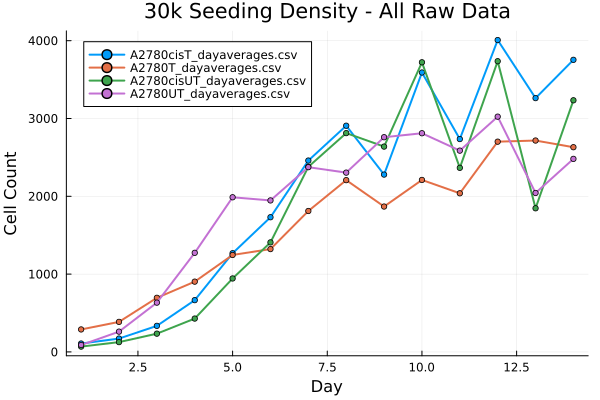

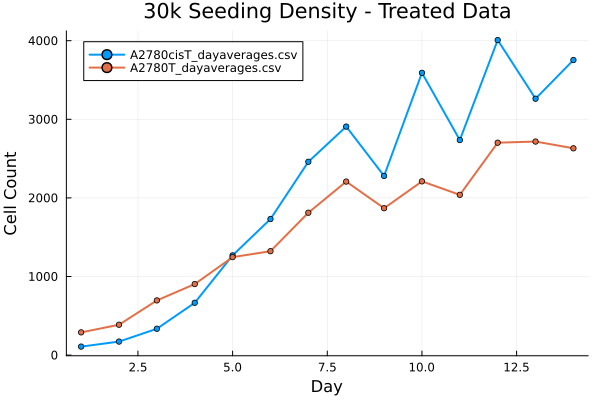

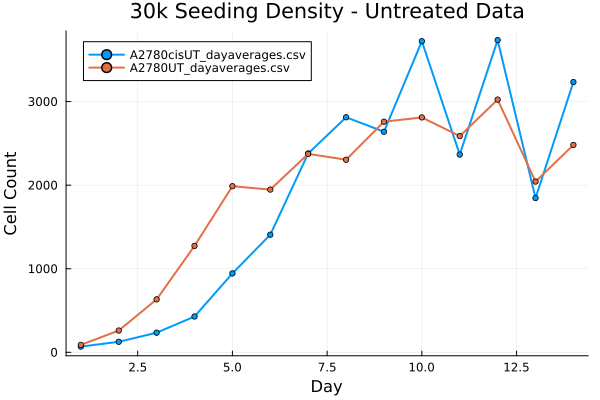

In [14]:
# Load and analyze 30k seeding density data
println("\nLoading 30k seeding density data...")
datasets_30k = load_intermittent_data("30k")

# Initialize storage for results
results_30k = Dict{String, Any}()
xy_data_30k = Dict{String, Tuple{Vector{Float64}, Vector{Float64}}}()

# Create plots to store all 30k data
plot_all_raw_30k = plot(title="30k Seeding Density - All Raw Data", xlabel="Day", ylabel="Cell Count", legend=:topleft)
plot_treated_30k = plot(title="30k Seeding Density - Treated Data", xlabel="Day", ylabel="Cell Count", legend=:topleft)
plot_untreated_30k = plot(title="30k Seeding Density - Untreated Data", xlabel="Day", ylabel="Cell Count", legend=:topleft)

# Process each dataset - JUST PLOTTING, NO MODEL FITTING
for (filename, df) in datasets_30k
    println("\n📊 Processing: $filename")
    
    # Extract x,y data
    x, y = extract_xy_from_dayaverages(df)
    xy_data_30k[filename] = (x, y)
    
    # Add raw data to overview plot as lines
    plot!(plot_all_raw_30k, x, y, label=filename, lw=2, marker=:circle, markersize=3)
    
    # Determine if treated or untreated
    is_treated = occursin("T_", filename) && !occursin("UT_", filename)
    
    if is_treated
        println("   → Adding to treated plot (no model fitting)")
        # Add raw data to treated plot as lines
        plot!(plot_treated_30k, x, y, label="$filename", lw=2, marker=:circle, markersize=3)
    else
        println("   → Adding to untreated plot (no model fitting)")
        # Add raw data to untreated plot as lines
        plot!(plot_untreated_30k, x, y, label="$filename", lw=2, marker=:circle, markersize=3)
    end
end

# Display 30k plots
println("\n📈 Displaying plots for 30k seeding density...")
display(plot_all_raw_30k)
display(plot_treated_30k)
display(plot_untreated_30k)

# Store empty results for 30k since we're not fitting models
results_30k = Dict{String, Any}()
for filename in keys(datasets_30k)
    results_30k[filename] = []  # Empty results since no model fitting
end

In [15]:
# Summary and comparison of results
function summarize_results(results_dict, seeding_density)
    println("\n" * "="^60)
    println("SUMMARY: $seeding_density Seeding Density Results")
    println("="^60)
    
    summary_data = []
    
    for (filename, file_results) in results_dict
        println("\n📁 $filename:")
        
        if !isempty(file_results)
            # Sort by BIC (lower is better)
            sorted_results = sort(file_results, by = x -> x[5])
            
            for (i, (model_name, params, sol, prob, bic, ssr)) in enumerate(sorted_results)
                rank_symbol = i == 1 ? "🥇" : i == 2 ? "🥈" : i == 3 ? "🥉" : "  "
                println("  $rank_symbol $model_name: BIC = $(round(bic, digits=2)), SSR = $(round(ssr, digits=6))")
                println("     Parameters: $(round.(params, digits=4))")
                
                push!(summary_data, (
                    SeeddingDensity = seeding_density,
                    File = filename,
                    Model = model_name,
                    BIC = bic,
                    SSR = ssr,
                    Parameters = join(round.(params, digits=4), ", "),
                    Rank = i
                ))
            end
        else
            println("  ❌ No successful fits")
        end
    end
    
    return summary_data
end

# Generate summaries
summary_20k = summarize_results(results_20k, "20k")
summary_30k = summarize_results(results_30k, "30k")

# Combine and save results
all_summaries = vcat(summary_20k, summary_30k)
summary_df = DataFrame(all_summaries)

# Save to CSV
CSV.write("intermittent_modeling_results.csv", summary_df)
println("\n💾 Results saved to: intermittent_modeling_results.csv")


SUMMARY: 20k Seeding Density Results

📁 A2780cisT_dayaverages.csv:
  ❌ No successful fits

📁 A2780T_dayaverages.csv:
  ❌ No successful fits

SUMMARY: 30k Seeding Density Results

📁 A2780cisT_dayaverages.csv:
  ❌ No successful fits

📁 A2780T_dayaverages.csv:
  ❌ No successful fits

📁 A2780cisUT_dayaverages.csv:
  ❌ No successful fits

📁 A2780UT_dayaverages.csv:
  ❌ No successful fits

💾 Results saved to: intermittent_modeling_results.csv


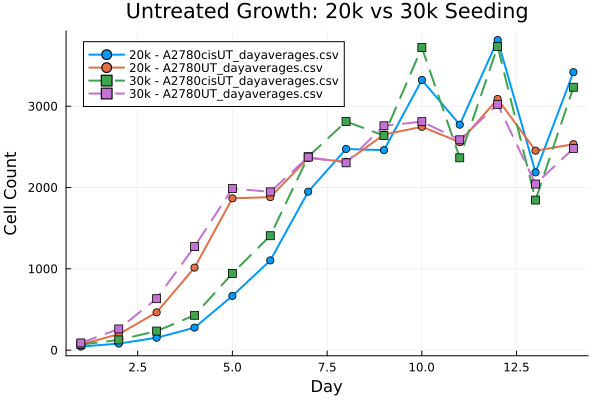

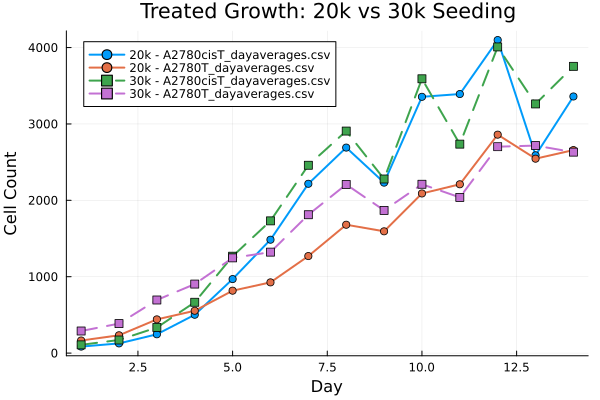

In [16]:
# Comparative plots: 20k vs 30k seeding densities
function create_comparative_plots()
    # Compare untreated growth between seeding densities
    plt_untreated = plot(title="Untreated Growth: 20k vs 30k Seeding", xlabel="Day", ylabel="Cell Count")
    
    # Plot 20k untreated data
    for filename in keys(xy_data_20k)
        if occursin("UT_", filename)
            x, y = xy_data_20k[filename]
            plot!(plt_untreated, x, y, label="20k - $filename", marker=:circle, lw=2)
        end
    end
    
    # Plot 30k untreated data
    for filename in keys(xy_data_30k)
        if occursin("UT_", filename)
            x, y = xy_data_30k[filename]
            plot!(plt_untreated, x, y, label="30k - $filename", marker=:square, lw=2, linestyle=:dash)
        end
    end
    
    display(plt_untreated)
    
    # Compare treated growth between seeding densities
    plt_treated = plot(title="Treated Growth: 20k vs 30k Seeding", xlabel="Day", ylabel="Cell Count")
    
    # Plot 20k treated data
    for filename in keys(xy_data_20k)
        if occursin("T_", filename) && !occursin("UT_", filename)
            x, y = xy_data_20k[filename]
            plot!(plt_treated, x, y, label="20k - $filename", marker=:circle, lw=2)
        end
    end
    
    # Plot 30k treated data
    for filename in keys(xy_data_30k)
        if occursin("T_", filename) && !occursin("UT_", filename)
            x, y = xy_data_30k[filename]
            plot!(plt_treated, x, y, label="30k - $filename", marker=:square, lw=2, linestyle=:dash)
        end
    end
    
    display(plt_treated)
end

create_comparative_plots()

## Analysis Summary

This notebook provides focused mathematical modeling for intermittent treatment data:

### Key Features:
1. **Organized Data Loading**: Directly loads from your processed datasets with exact seeding densities
2. **Multiple Model Types**: 
   - Standard logistic growth (untreated)
   - Exponential drug decay model
   - Intermittent treatment model (step function)
   - Hill function drug response
3. **Comparative Analysis**: Side-by-side comparison of 20k vs 30k seeding densities
4. **Model Selection**: BIC-based ranking to identify best-fitting models
5. **Results Export**: Comprehensive CSV output for further analysis

### Data Structure:
- Loads from: `Processed_Datasets/Intermittent Data/{20k,30k}_seeding_density/Averages/`
- Processes: Day-averaged cell count data
- Handles: Both naive (A2780) and resistant (A2780cis) cell lines
- Compares: Treated vs untreated conditions

### Output:
- Individual model fits with plots
- BIC comparison for model selection
- Summary CSV file with all parameters
- Comparative visualizations